In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [3]:
_parent_folder = "multi_cam_nov_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\multi_cam_nov_14'

In [4]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files.xlsx"))
folder_df

,folder_name,calibration_folder,flip
0,sk16_15_forward_fast,calibration_15fps_sk,False
1,sk16_15_forward_fast_2,calibration_15fps_sk,False
2,sk16_15_forward_medium,calibration_15fps_sk,False
3,sk16_15_forward_medium_2,calibration_15fps_sk,False
4,sk16_15_forward_slow,calibration_15fps_sk,False
...,...,...,...
84,sk16_60_sideways_fast_2,calibration_60fps_quad_sk_3,False
85,sk16_60_sideways_medium,calibration_60fps_quad_sk_3,False
86,sk16_60_sideways_medium_2,calibration_60fps_quad_sk_3,False
87,sk16_60_sideways_slow,calibration_60fps_quad_sk_3,False


In [18]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        # _val = _val
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [19]:
mean_err_df = pd.DataFrame(columns=["folder_name", "err_x", "err_y", "err_z"])

In [20]:
for i in range(len(folder_df)):
    folder_no = i
    #open the calibration files
    _pth = folder_df.folder_name[folder_no]
    _pth = os.path.join(_base_pth, _pth)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[folder_no]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)
    _webcam_calib_pth = os.path.join(_base_pth, _webcam_calib_folder, "webcam_calibration.msgpack")


    with open(_webcam_calib_pth, "rb") as f:
        webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
        _temp = next(webcam_calib)
        _webcam_cam_mat = _temp[0]
        _webcam_dist = _temp[1]
    _webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")
    _webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")


    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)

    
    _w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

    _w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)
    w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

    mc_df_pth = os.path.join(_base_pth, folder_df.folder_name[folder_no].split("_")[0], folder_df.folder_name[folder_no]+ ".csv")
    _m_df, st_time = read_df_csv(mc_df_pth)
    _m_df = add_datetime_col(_m_df, st_time, _name="seconds")


    _m_df["x"] = _m_df["lb_x"] + _m_df["rb_x"] + _m_df["lt_x"] + _m_df["rt_x"]
    _m_df["y"] = _m_df["lb_y"] + _m_df["rb_y"] + _m_df["lt_y"] + _m_df["rt_y"]
    _m_df["z"] = _m_df["lb_z"] + _m_df["rb_z"] + _m_df["lt_z"] + _m_df["rt_z"]

    _m_df["x"] = _m_df["x"] / 4
    _m_df["y"] = _m_df["y"] / 4
    _m_df["z"] = _m_df["z"] / 4

    w_df, _m_df = trunkate_dfs(w_df, _m_df)

    w_df = interpolate_target_df(w_df, _m_df)

    error_df = pd.DataFrame()
    error_df["time"] = _m_df["time"]
    error_df["x"] = _m_df["x"] - w_df["x"]
    error_df["y"] = _m_df["y"] - w_df["y"]
    error_df["z"] = _m_df["z"] - w_df["z"]

    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[folder_no], "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(), "err_z": error_df["z"].mean()}, ignore_index=True)

    

returning dataframe
33
df_1 starts earlier
304
df_1 ends later
returning dataframe
21
df_1 starts earlier
286
df_1 ends later
returning dataframe
23
df_1 starts earlier
280
df_1 ends later
returning dataframe
25
df_1 starts earlier
299
df_1 ends later
returning dataframe
67
df_1 starts earlier
512
df_1 ends later
returning dataframe
43
df_1 starts earlier
368
df_1 ends later
returning dataframe
37
df_1 starts earlier
3329
df_2 ends later
returning dataframe
45
df_1 starts earlier
526
df_1 ends later
returning dataframe
25
df_1 starts earlier
3137
df_2 ends later
returning dataframe
35
df_1 starts earlier
3400
df_2 ends later
returning dataframe
33
df_1 starts earlier
3790
df_2 ends later
returning dataframe
47
df_1 starts earlier
398
df_1 ends later
returning dataframe
34
df_1 starts earlier
3433
df_2 ends later
returning dataframe
37
df_1 starts earlier
3995
df_2 ends later
returning dataframe
22
df_1 starts earlier
389
df_1 ends later
returning dataframe
16
df_1 starts earlier
506
df

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\multi_cam_nov_14\\sk16\\sk16_30_random_slow.csv'

In [24]:

mean_err_df



,folder_name,err_x,err_y,err_z
0,sk16_15_forward_fast,0.000526,-0.012339,0.015757
1,sk16_15_forward_fast_2,-0.000540,-0.012633,0.013277
2,sk16_15_forward_medium,-0.000363,-0.012625,0.012512
3,sk16_15_forward_medium_2,-0.000078,-0.012516,0.013455
4,sk16_15_forward_slow,-0.001282,-0.012496,0.015094
5,sk16_15_forward_slow_2,-0.001051,-0.011648,0.019936
6,sk16_15_quad_fast,-0.014152,0.011446,0.173623
7,sk16_15_quad_fast_2,0.005173,0.004635,0.069677
8,sk16_15_quad_medium,0.000931,0.005064,0.069790
9,sk16_15_quad_medium_2,0.000473,0.003026,0.085923


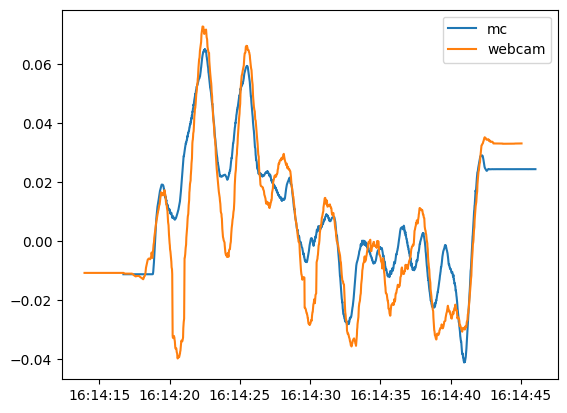

In [12]:


plt.plot(_m_df["time"], _m_df["z"], label="mc")
# plt.plot(_w_df["time"], _w_df["z"].rolling(13).median()*-1  +1.5, label="webcam")
plt.plot(w_df["time"], savgol_filter(w_df["z"].values, 51, 1, mode='nearest') + 0.045, label="webcam")
plt.legend()


In [13]:
w_df, _m_df = trunkate_dfs(w_df, _m_df)

166
df_1 starts earlier
2834
df_2 ends later


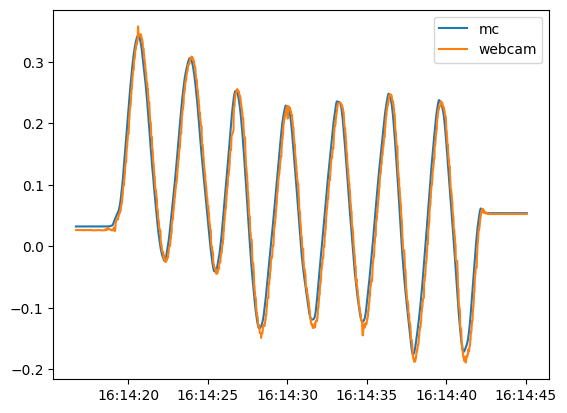

In [14]:
plt.plot(_m_df["time"], _m_df["x"], label="mc")
plt.plot(w_df["time"], w_df["x"], label="webcam")
plt.legend()

In [15]:
w_df = interpolate_target_df(w_df, _m_df)

In [16]:
# find error between x , y, z and yaw, pitch, roll
error_df = pd.DataFrame()
error_df["time"] = _m_df["time"]
error_df["x"] = _m_df["x"] - w_df["x"]
error_df["y"] = _m_df["y"] - w_df["y"]
error_df["z"] = _m_df["z"] - w_df["z"]

In [17]:
print(error_df.x.mean())
print(error_df.y.mean())
print(error_df.z.mean())

0.0038566442979683308
-0.0042271954169964855
0.04903025857072213
